In [11]:
import matplotlib
matplotlib.use("TkAgg")

In [2]:
import umap

C:\Users\demje\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [156]:
# Collect Images
import requests as rq

for i in range (1, 152):
    data = rq.get(f"https://pokeapi.co/api/v2/pokemon/{i}/").json()
    img = rq.get(data['sprites']['other']['home']['front_default']).content

    with open(f"./pokemon_imgs_home/{i}.png", "wb") as f:
        f.write(img)

In [3]:
# Process images
import cv2
import numpy as np
import glob # regex

imgs = []
names = []

for path in sorted(glob.glob("./pokemon_imgs_home/*.png")):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))

    imgs.append(img)
    names.append(path)



In [20]:
# Feature extraction

import tensorflow as tf

model = tf.keras.applications.ResNet50(
    pooling = 'avg',
    include_top = False,
    
)

In [21]:
def embed(img):
    x = tf.keras.applications.resnet50.preprocess_input(img)
    x = np.expand_dims(x,axis=0)
    return model.predict(x)[0]

embeddings = np.array([embed(img) for img in imgs])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/

In [81]:
# PCA for dimensionality reduction
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(embeddings)

#  Instead:
X = embeddings.copy()
# print(X.shape) (151, 2048)

# Center values
X_mean = X.mean(axis=0)
X_centered = X - X_mean 
# Covariance matrix
covariance_matrix = (X_centered.T @ X_centered) / X.shape[0]

# Find eigenvalues and vectors
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

#  Sort by eigenvalues/variance
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[idx]

print(sum([x > 0 for x in eigenvalues]))

# Project onto top k components
n_components = 2
principal_components = eigenvectors[:,:n_components]
X_pca = X_centered @ principal_components

print(f"Reduced from {X.shape} to {X_pca.shape}")

1097
Reduced from (151, 2048) to (151, 2)


In [56]:
# Calculate cumulative variance explained
variance_explained = eigenvalues / eigenvalues.sum()
cumulative_variance = np.cumsum(variance_explained)

print(cumulative_variance)
# Find how many components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Need {n_components_95} components for 95% variance")


[0.08128893 0.14080739 0.19768369 ... 1.         1.         1.        ]
Need 97 components for 95% variance


In [82]:
# clustering
def manual_kmeans(X, k = 10, random_state = 31, max_iter = 100):
    """
    X - data entry
    k - nr of clusters (def 10)
    """
    np.random.seed(random_state)
    n_samples = X.shape[0]

    # Randomly select K cluster centers
    random_indices = np.random.choice(n_samples, k, replace=False)
    centers = X[random_indices].copy()

    for i in range(max_iter):
        # get distances to centers
        distances = np.zeros((n_samples,k))
        for i in range(n_samples):
            for j in range(k):
                # Euclidean dist
                distances[i, j] = np.sqrt(np.sum(X[i] - centers[j])**2)

        labels = np.argmin(distances, axis=1)

        # recalculate cluster centers
        new_centers = np.zeros_like(centers)
        for j in range(k):
            cluster_elements = X[labels == j]
            if len(cluster_elements > 0):
                new_centers[j] = cluster_elements.mean(axis = 0)
            else:
                # empty cluster
                new_centers[j] = X[np.random.randint(n_samples)]

        # center move
        center_shift = np.sum((new_centers-centers)**2)
        if center_shift < 1e-6:
            print(f"Converging at iteration {i}")
            break
        centers = new_centers
        if (i + 1) % 20 == 0:
            print(f"Iteration {i + 1}: shift = {center_shift:.6f}")
    
    return labels, centers

labels, centers = manual_kmeans(X_pca, k=15, random_state=42)
print(f"Cluster assignments: {labels}")

Converging at iteration 150
Cluster assignments: [ 2  4 13  9 13 12  9  3 10  2  5 12  6  7  3  2  5  5  1 14  2  2 12  5
 12  0 12 11  0 14  2 13  3  7 13  4  0  3  4 12 12 12 12 11  2 10  4  1
  8  2 11 12  8 12 13  1  6 13 13  1 11  7 14 12  7 14  5 13  7  6  9 12
  5 12 13 13  0 11  7  7 13 13  2 13  5  9  9  2  6  2  3 13  7 13 13 12
  8  2 13 12 12  0 12  3 11 12 13 13  8  7  8 13  0  6  4  9 13 11 13  6
 13  5  3 11  7  1  6  4 13 12  0  4  7  8  0 12  5  2  1 14  2  0  6  4
  1  2  6  7  6  5  3]


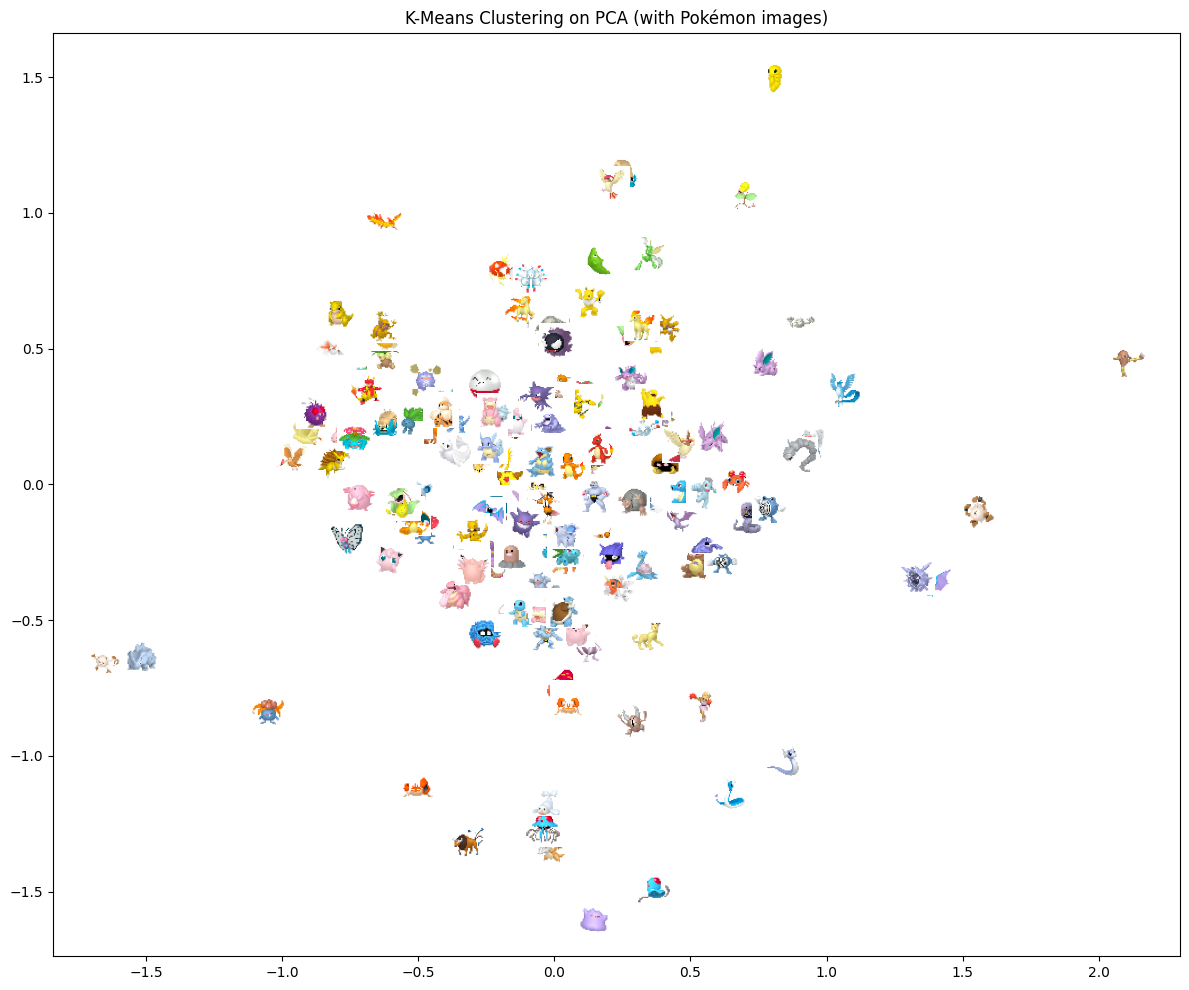

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.show()

In [192]:
print("Starting UMAP…")
umap2d = umap.UMAP(
    n_components=2,
    n_neighbors=10,
    min_dist=0.3,
    n_jobs=-1,
    densmap=False,
    low_memory=True,
    metric='euclidean',
    verbose=True,
    random_state=42
).fit_transform(X_pca)
print("UMAP finished.")

C:\Users\demje\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Starting UMAP…
UMAP(min_dist=0.3, n_jobs=1, n_neighbors=10, random_state=42, verbose=True)
Fri Dec  5 16:34:57 2025 Construct fuzzy simplicial set
Fri Dec  5 16:34:57 2025 Finding Nearest Neighbors
Fri Dec  5 16:34:57 2025 Finished Nearest Neighbor Search
Fri Dec  5 16:34:57 2025 Construct embedding


Epochs completed:  27%| ██▋        136/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:00]

	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec  5 16:34:57 2025 Finished embedding
UMAP finished.


In [ ]:
import matplotlib.pyplot as plt

embedding_2d = umap.UMAP(n_components=97, random_state=42).fit_transform(embeddings)
print(embedding_2d.shape)
plt.figure(figsize=(10, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10)
plt.title("UMAP of Pokémon Embeddings")
plt.show()

C:\Users\demje\AppData\Roaming\Python\Python310\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


AttributeError: 'numpy.ndarray' object has no attribute 'n_neighbors'

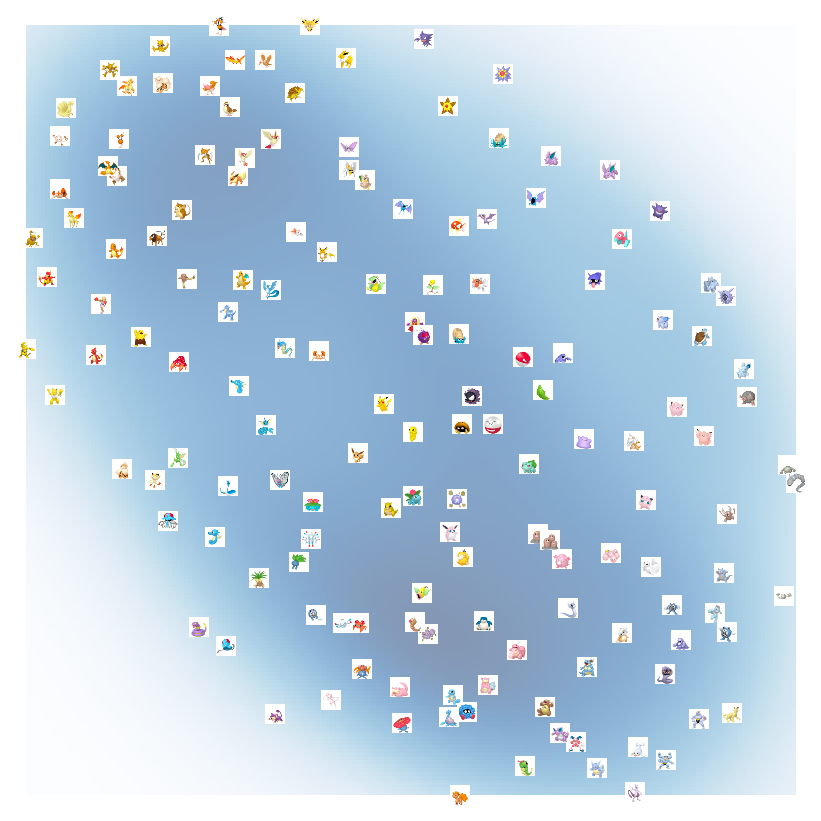

In [197]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import gaussian_kde
# 1. Correct RGBA → RGB
def rgba_to_rgb(img):
    if img.shape[2] == 4:
        alpha = img[:, :, 3] / 255.0
        rgb = img[:, :, :3].astype(np.float32)
        rgb = rgb * alpha[..., None] + 255 * (1 - alpha[..., None])
        return np.clip(rgb, 0, 255).astype(np.uint8)
    else:
        return img

imgs_fixed = [rgba_to_rgb(img) for img in imgs]

# 2. Normalize UMAP coordinates to 0–1 to prevent overlap
X = embedding_2d
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# 3. Compute density for gradient background using Gaussian KDE
xy = np.vstack([X_norm[:,0], X_norm[:,1]])
z = gaussian_kde(xy)(xy)
# Optional: create a grid for smoother background
xi = np.linspace(0, 1, 200)
yi = np.linspace(0, 1, 200)
xi, yi = np.meshgrid(xi, yi)
zi = gaussian_kde(xy)(np.vstack([xi.ravel(), yi.ravel()]))
zi = zi.reshape(xi.shape)

# Optional downscale for thumbnails
imgs_small = [cv2.resize(img, (48,48), interpolation=cv2.INTER_AREA) for img in imgs_fixed]


# 4. Plot gradient background
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.imshow(
    zi, origin='lower', extent=(0,1,0,1),
    cmap='Blues', alpha=0.5  # alpha controls transparency of gradient
)

for (x0, y0, img) in zip(X_norm[:,0], X_norm[:,1], imgs_small):
    ab = AnnotationBbox(OffsetImage(img, zoom=0.30), (x0, y0), frameon=False)
    ax.add_artist(ab)

plt.axis('off')
plt.show()



=== Cluster 0 (9 Pokémon) ===


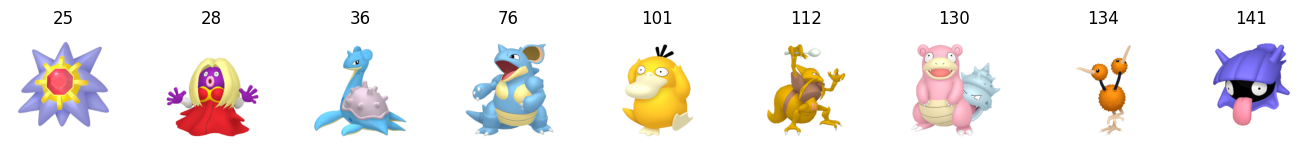


=== Cluster 1 (7 Pokémon) ===


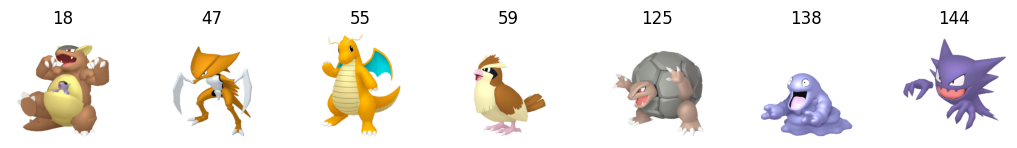


=== Cluster 2 (15 Pokémon) ===


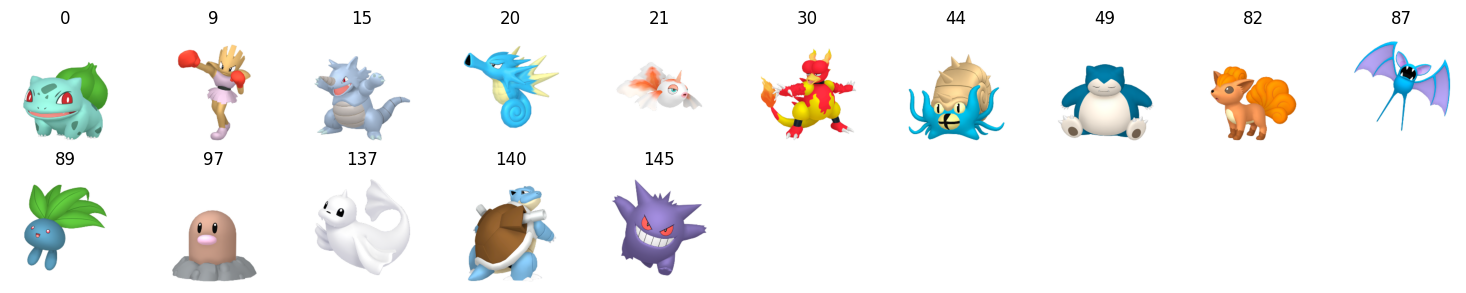


=== Cluster 3 (8 Pokémon) ===


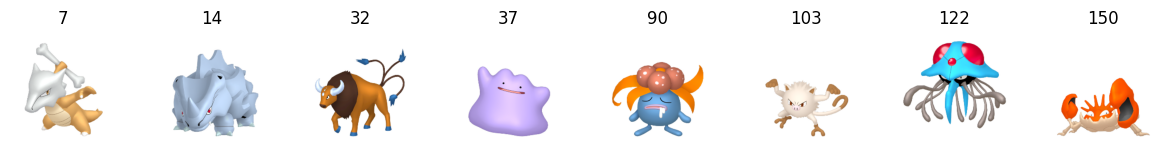


=== Cluster 4 (8 Pokémon) ===


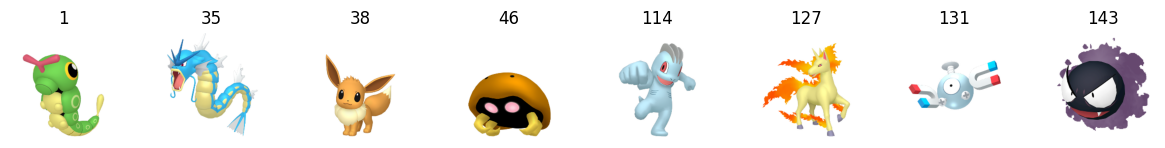


=== Cluster 5 (10 Pokémon) ===


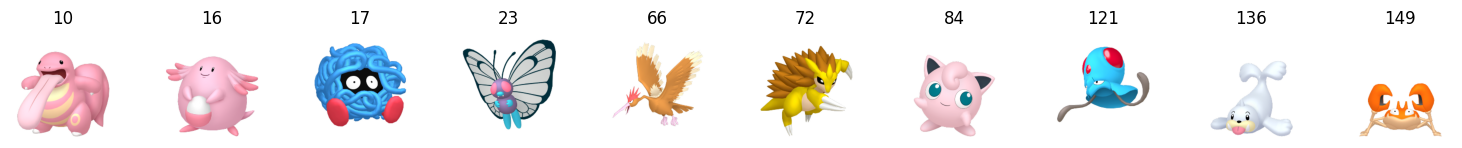


=== Cluster 6 (10 Pokémon) ===


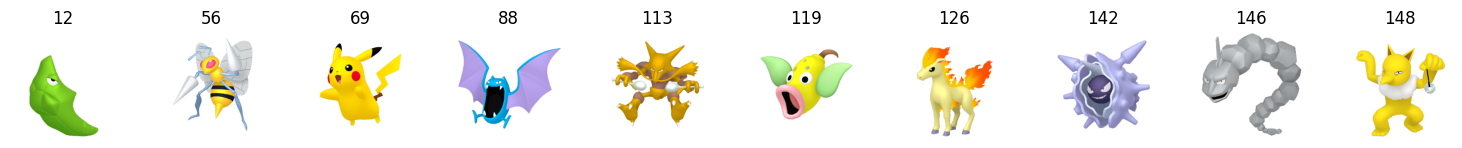


=== Cluster 7 (12 Pokémon) ===


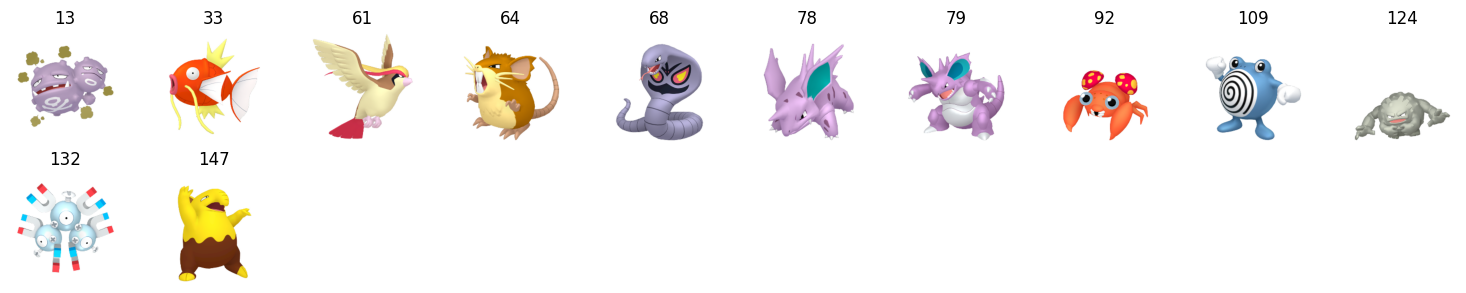


=== Cluster 8 (6 Pokémon) ===


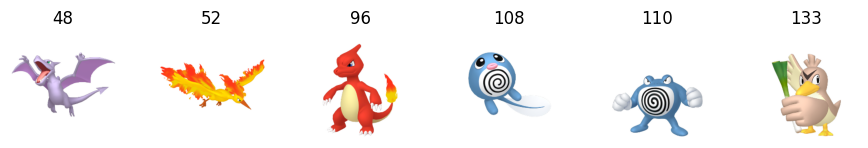


=== Cluster 9 (6 Pokémon) ===


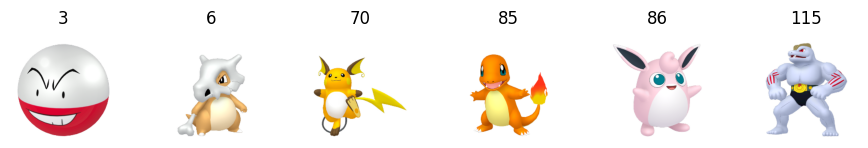


=== Cluster 10 (2 Pokémon) ===


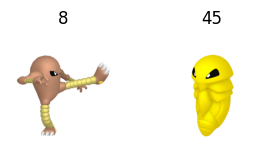


=== Cluster 11 (8 Pokémon) ===


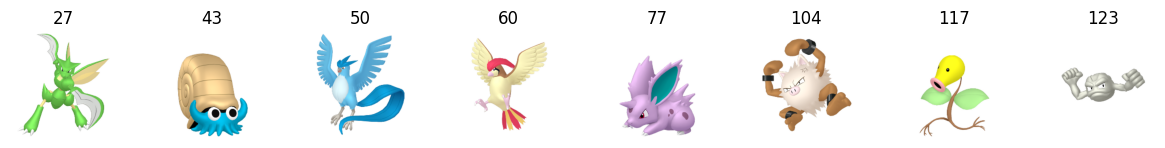


=== Cluster 12 (21 Pokémon) ===


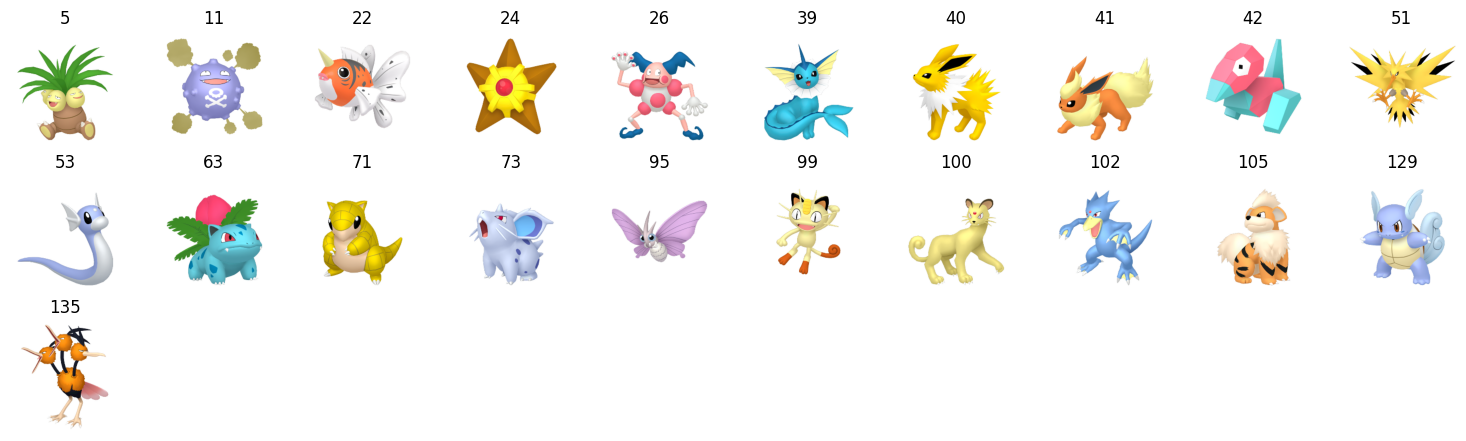


=== Cluster 13 (24 Pokémon) ===


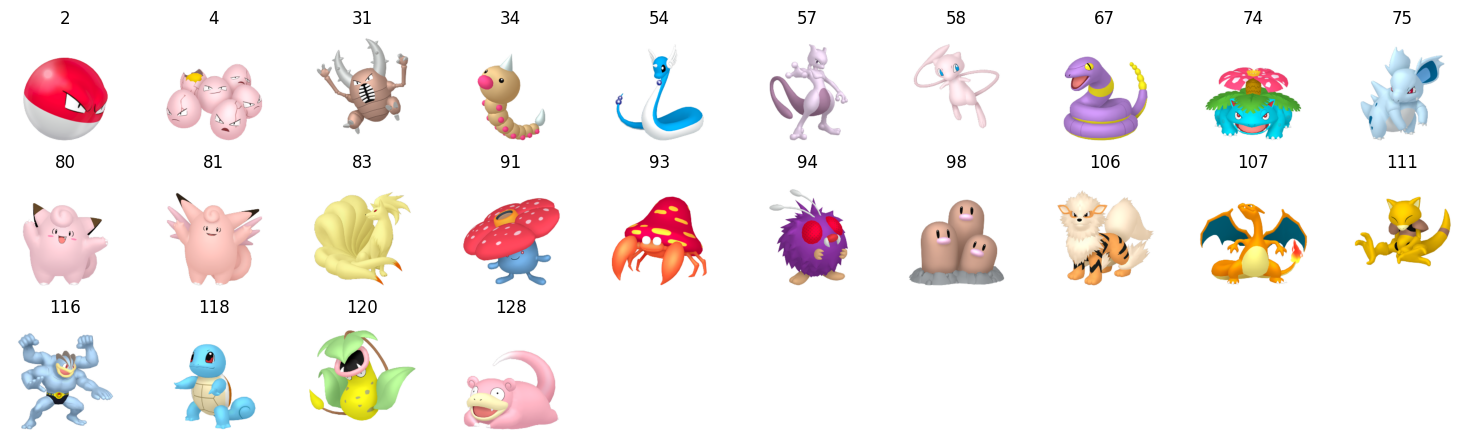


=== Cluster 14 (5 Pokémon) ===


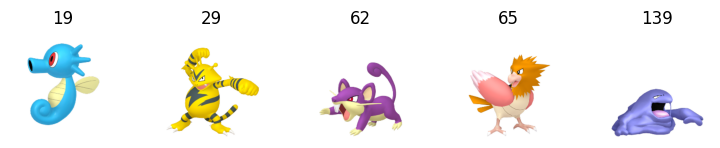

In [84]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(labels)  # ensure it's a NumPy array
unique_clusters = np.unique(labels)

for cluster_id in unique_clusters:
    # get indexes of Pokémon in this cluster
    idxs = np.where(labels == cluster_id)[0]

    print(f"\n=== Cluster {cluster_id} ({len(idxs)} Pokémon) ===")

    # number of images you want per row
    per_row = 10
    rows = int(np.ceil(len(idxs) / per_row))

    plt.figure(figsize=(per_row * 1.5, rows * 1.5))
    
    for i, idx in enumerate(idxs):
        plt.subplot(rows, per_row, i + 1)
        plt.imshow(imgs[idx])      # show image
        plt.axis('off')
        plt.title(str(idx))
    
    plt.tight_layout()
    plt.show()
